# Clustering and Fitting - House Price Analysis

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Data Cleaning and Preparation

In [2]:
# Function to clean and prepare the dataset
def clean_and_prepare_data(data):
    """
    Cleans and prepares the dataset by filling missing values with the mean
    """
    data.fillna(data.mean(), inplace=True)
    return data

# Load and clean the dataset
file_path = 'house_price_regression_dataset.csv'
data = pd.read_csv(file_path)
data = clean_and_prepare_data(data)

## Correlation Heatmap

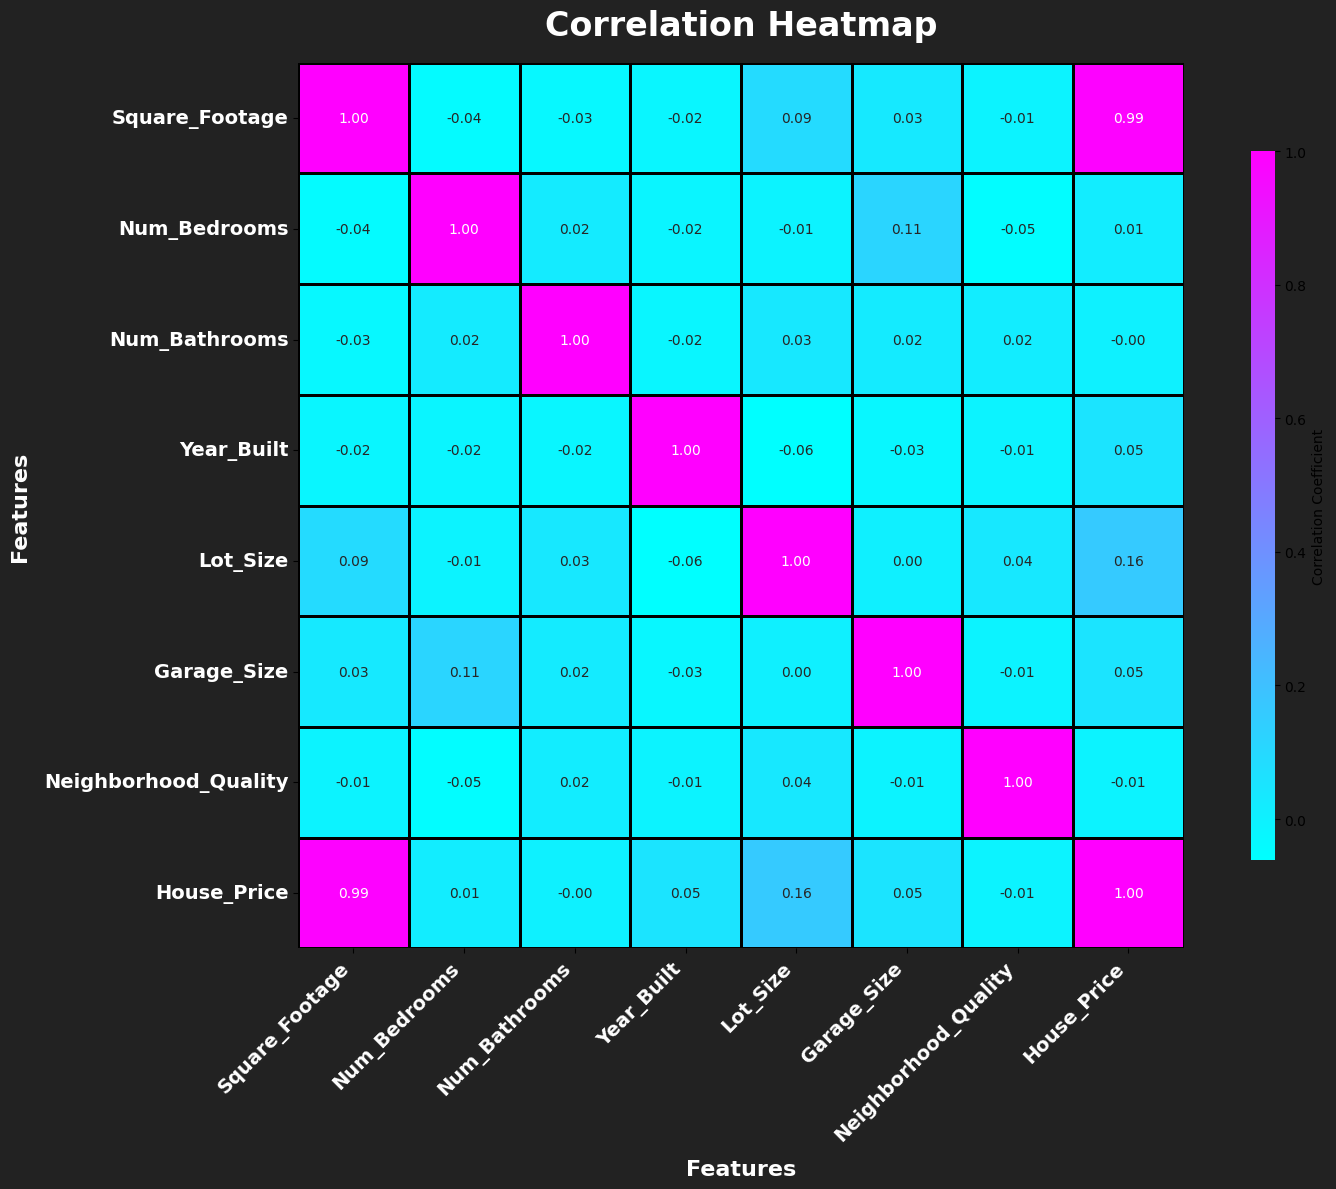

In [3]:
# Function to plot heatmap
def plot_heatmap(data):
    """
    Creates a heatmap to visualize feature correlations using a cool gradient palette
    """
    plt.figure(figsize=(16, 12))
    correlation_matrix = data.corr()

    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        fmt='.2f', 
        cmap='cool', 
        cbar_kws={
            'shrink': 0.8, 'aspect': 30, 'orientation': 'vertical', 
            'label': 'Correlation Coefficient'
        },
        linewidths=1.0, 
        linecolor='black', 
        square=True
    )
    
    # Add title and axis labels
    plt.title('Correlation Heatmap', fontsize=24, weight='bold', pad=20, color='white')
    plt.xticks(fontsize=14, rotation=45, ha='right', color='white', weight='bold')
    plt.yticks(fontsize=14, color='white', weight='bold')
    plt.xlabel('Features', fontsize=16, weight='bold', labelpad=10, color='white')
    plt.ylabel('Features', fontsize=16, weight='bold', labelpad=10, color='white')

    # Dark background
    plt.gca().set_facecolor('#333333')
    plt.gcf().set_facecolor('#222222')

    # Improve layout
    plt.tight_layout()
    plt.show()

# Generate heatmap
plot_heatmap(data)

## Elbow Method Plot

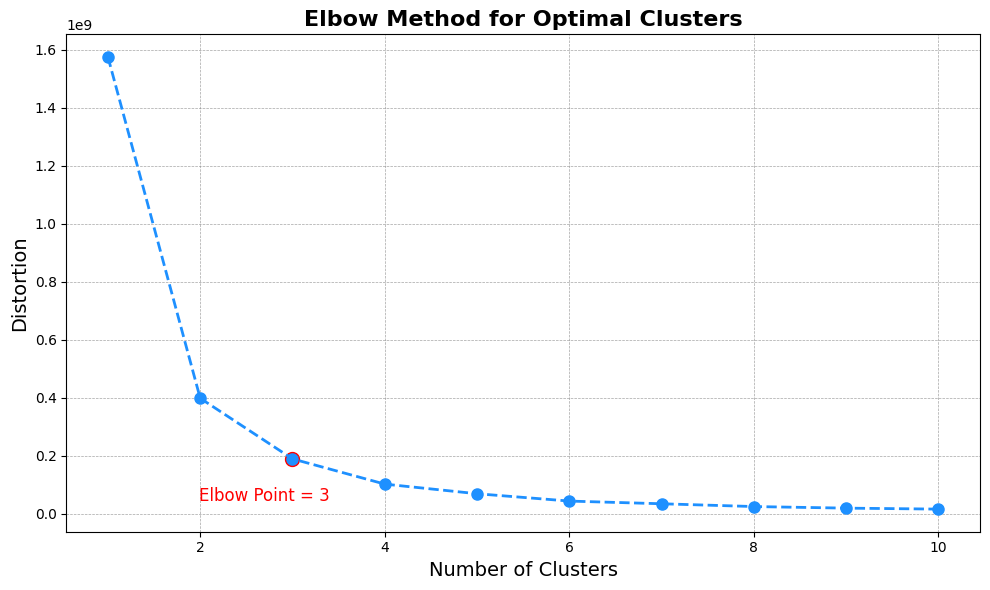

In [4]:
# Function to plot elbow method
def plot_elbow_method(data, max_clusters=10):
    """
    Displays the Elbow Method for choosing optimal K in K-means
    """
    clustering_features = data[['Square_Footage', 'Lot_Size']]
    distortions = [KMeans(n_clusters=k, random_state=42).fit(clustering_features).inertia_ for k in range(1, max_clusters + 1)]
    
    # Plot with elbow point
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o', color='dodgerblue', markersize=8, linestyle='--', linewidth=2)
    
    # Annotate elbow point
    elbow_point = 3
    plt.scatter(elbow_point, distortions[elbow_point - 1], color='red', s=100, label=f'Elbow Point ({elbow_point})')
    plt.annotate(f'Elbow Point = {elbow_point}', (elbow_point, distortions[elbow_point - 1]), 
                 textcoords="offset points", xytext=(-20, -30), ha='center', fontsize=12, color='red')

    plt.title('Elbow Method for Optimal Clusters', fontsize=16, weight='bold')
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Distortion', fontsize=14)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

# Generate elbow plot
plot_elbow_method(data)


## K-means Clustering

In [5]:
# Function to perform K-means clustering
def kmeans_clustering(data, n_clusters=3):
    """
    Applies K-means clustering on Square Footage and Lot Size
    """
    clustering_features = data[['Square_Footage', 'Lot_Size']]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(clustering_features)
    data['Cluster'] = clusters
    return data, kmeans

# Perform clustering
data, kmeans_model = kmeans_clustering(data)

## Scatter Plot for Clustering

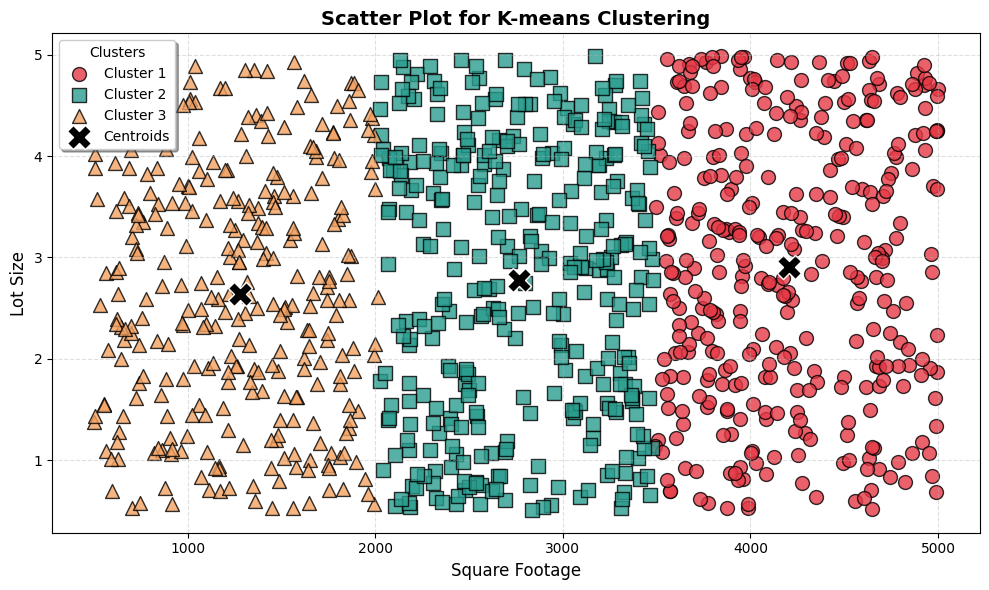

In [6]:
# Function to create scatter plot for clusters
def scatter_plot(data, kmeans_model):
    """
    Creates a scatter plot with color-coded clusters and centroids
    """
    plt.figure(figsize=(10, 6))
    cluster_colors = ['#E63946', '#2A9D8F', '#F4A261']
    markers = ['o', 's', '^']

    for cluster_id, (color, marker) in enumerate(zip(cluster_colors, markers)):
        cluster_data = data[data['Cluster'] == cluster_id]
        plt.scatter(
            cluster_data['Square_Footage'],
            cluster_data['Lot_Size'],
            color=color,
            alpha=0.8,
            edgecolor='black',
            s=100,
            label=f'Cluster {cluster_id + 1}',
            marker=marker
        )

    # Add centroids
    plt.scatter(
        kmeans_model.cluster_centers_[:, 0],
        kmeans_model.cluster_centers_[:, 1],
        c='black', edgecolor='white', s=300, marker='X', label='Centroids'
    )
    plt.title('Scatter Plot for K-means Clustering', fontsize=14, weight='bold')
    plt.xlabel('Square Footage', fontsize=12)
    plt.ylabel('Lot Size', fontsize=12)
    plt.legend(title='Clusters', fontsize=10, loc='upper left', frameon=True, shadow=True)
    plt.grid(alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

# Plot clustering results
scatter_plot(data, kmeans_model)

## Pairwise Relationships Across Clusters

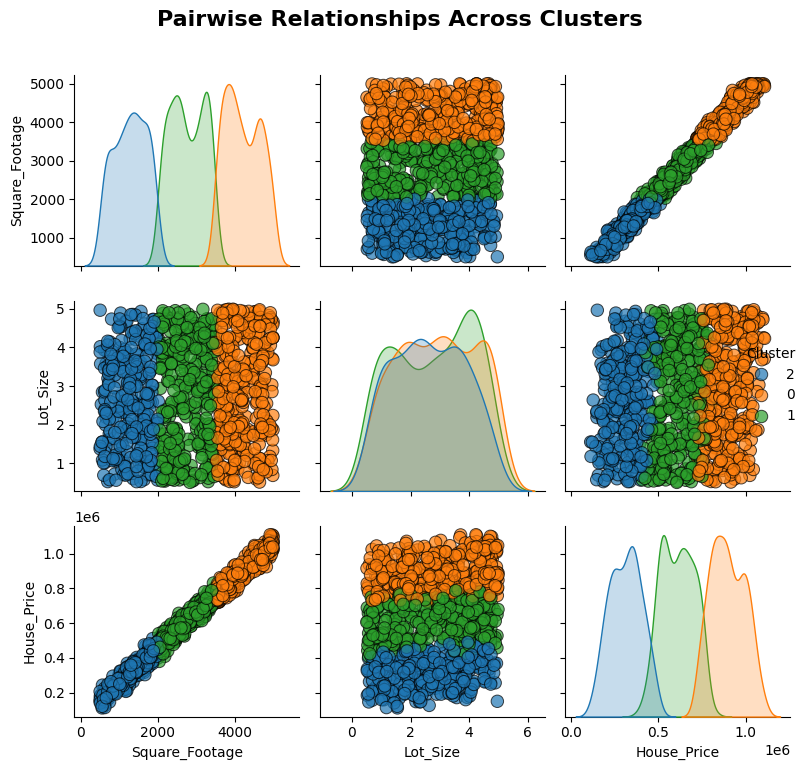

In [7]:
# Function to create pair plot for key features
def plot_pairwise_relationships(data):
    """
    Creates a pair plot to visualize relationships between key features across clusters.
    """
    # Select key features for visualization
    features = ['Square_Footage', 'Lot_Size', 'House_Price', 'Cluster']
    data['Cluster'] = data['Cluster'].astype(str)  # Convert clusters to categorical

    sns.pairplot(
        data[features], 
        hue='Cluster', 
        palette='tab10', 
        diag_kind='kde',
        plot_kws={'alpha': 0.7, 's': 80, 'edgecolor': 'k'}
    )

    plt.suptitle('Pairwise Relationships Across Clusters', y=1.02, fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

# Generate pair plot
plot_pairwise_relationships(data)


## Linear Regression

In [8]:
# Function to perform linear regression
def linear_regression(data):
    """
    Trains a linear regression model to predict house prices
    """
    X = data[['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built', 'Lot_Size', 'Garage_Size']]
    y = data['House_Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, y_pred, X_test, y_test

# Perform regression
reg_model, predictions, X_test, y_test = linear_regression(data)


## Model Evaluation

In [9]:
# Function to evaluate the model
def evaluate_model(y_test, predictions):
    """
    Prints evaluation metrics for the regression model.
    """
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

# Evaluate regression performance
evaluate_model(y_test, predictions)

Mean Squared Error: 101211537.28
R^2 Score: 1.00


## Enhanced Scatter Plot for Regression Results

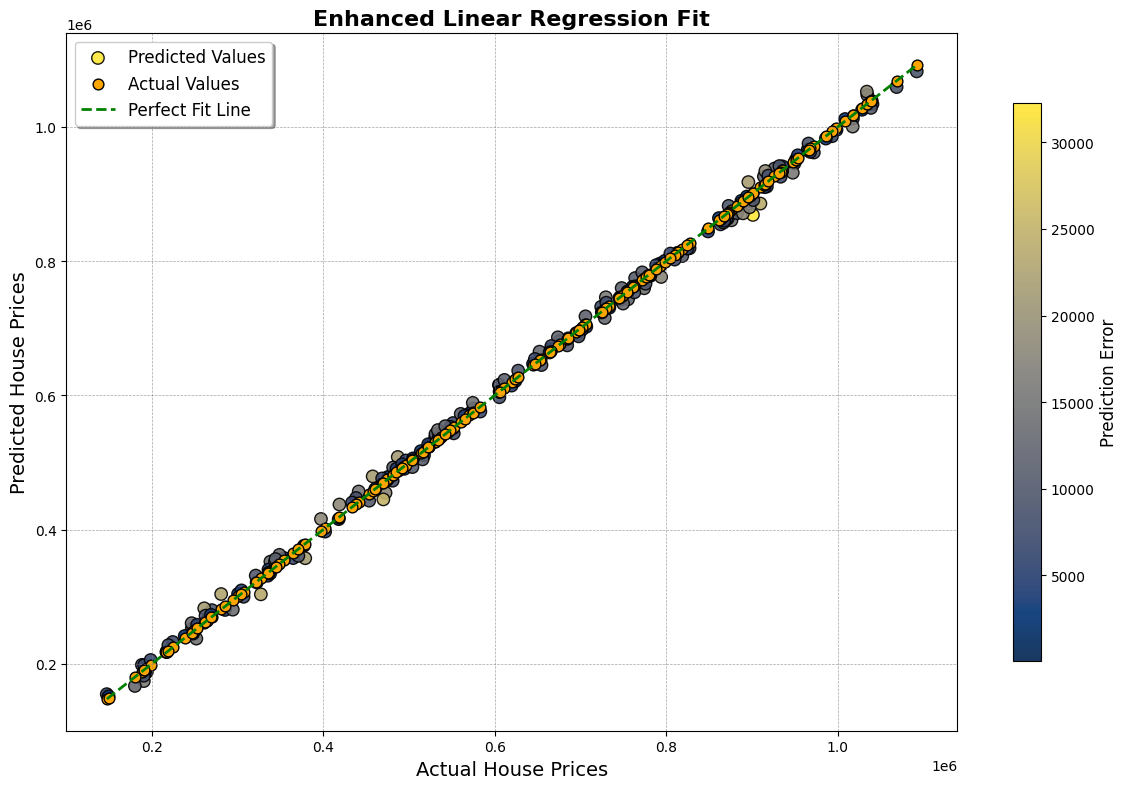

In [10]:
# Function to plot enhanced regression fit
def enhanced_scatter_plot(y_test, predictions):
    """
    Visualizes actual vs. predicted house prices using a gradient plot.
    """
    plt.figure(figsize=(12, 8))
    error = np.abs(predictions - y_test)
    scatter = plt.scatter(
        y_test, predictions, c=error, cmap='cividis', edgecolor='black', s=80, alpha=0.9, label='Predicted Values'
    )
    plt.scatter(y_test, y_test, c='orange', edgecolor='black', s=60, marker='o', label='Actual Values')
    plt.plot(
        [min(y_test), max(y_test)], [min(y_test), max(y_test)],
        color='green', linestyle='--', linewidth=2, label='Perfect Fit Line'
    )
    cbar = plt.colorbar(scatter, shrink=0.8)
    cbar.set_label('Prediction Error', fontsize=12)
    plt.title('Enhanced Linear Regression Fit', fontsize=16, weight='bold')
    plt.xlabel('Actual House Prices', fontsize=14)
    plt.ylabel('Predicted House Prices', fontsize=14)
    plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
    plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize regression results
enhanced_scatter_plot(y_test, predictions)

# Insights from the data:

#### 1. Square Footage Matters: With a high positive correlation, square footage is clearly the most significant element influencing home prices.
#### 2. Less Important Features: In comparison to square footage, features like lot size, number of bedrooms, and number of bathrooms have less bearing on home values.
#### 3. Optimal Cluster Count: According to the Elbow Method, meaningful segmentation is best achieved by splitting the dataset into three groups.
#### 4. Clearly Defined Groups: Three different home size groups—from little to huge properties—are displayed in the scatter plot.
#### 5. Feature Relationships: The pair plot shows that lot size has less of an impact on pricing, while larger residences are often more expensive.
#### 6. Accurate Predictions: The regression model has good performance, as evidenced by its high R2 score and low error rates.
#### 7. Visual Confirmation: With only a few minor deviations, the regression fit plot shows that the majority of projected home prices nearly match actual values.
#### 8. Key Finding: Based on clustering, regression, and perceptive visualisations, Square_Footage is the most important factor affecting home prices.